<a href="https://colab.research.google.com/github/IbramMedhat/Deep-Metric-Learning-using-Triplet-Net/blob/main/Deep_metric_learning_using_triplet_network_Ibram_Abdelmalak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep metric Learning using Triplet Network

Agenda :



*   Introduction into the concepts of metric learning and triplet networks
*   Load the data and preprocess it
*   Build the main embedding network
*   Build optimizer routine including triplet loss and triplet batch generator
*   Experiement Running (visualization and classification accuracy) 
*   Conclusion









# Introduction

*   What is deep metric learning?

It is the process of transforming data into another feature space where the task to be done is easier. in a more general terms it is learning new **metric** for distances between different instance for example if we are having a classification task in hand with the seperation of instances in the original space is not good enough, metric learning suggests to transform these instance into a new feature space where it is easier to seperate different classes. which can be seen from the figure below[1] as the learning process goes on the seperation between classes is higher.



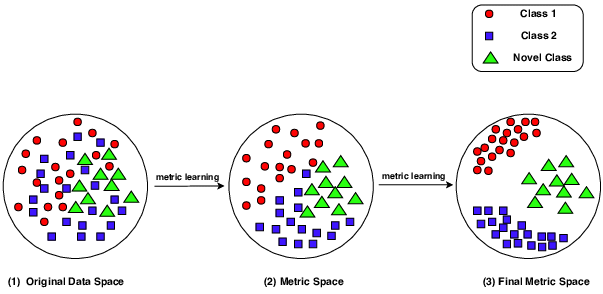





*  This notebook demonstrate the power of metric learning in image classification task on different datasets using triplet networks.
*   Triplet networks depends on applying embedding model on three training instances at the same time (anchor image, positive image and negative image) where the positive and anchor image are from the same class and the negative image is from another class. then comparing the distance between these instances in the embedding space using a triplet loss function (which will be explained later in the notebook). The triplet net architicture is demonstrated in the following figure[2].
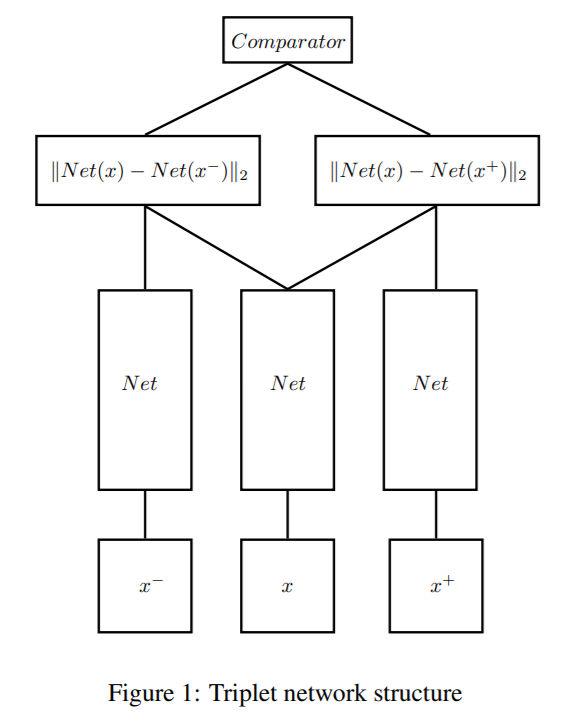


In this figure we can see the embedding network (Net) applied on three training isntances (x, x+, x-) where x and x+ are from the same class and x- is from another class then euclidean distances between the embedding of x and x+ is calculated, also the euclidean distance between the embedding of x and x- is calculated and afterwards the Comparator job is defined by the loss function which will be explained later



In the remaining of the notebook, I will show step by step the building process of a triplet network for image classification tasks applied on different datasets

# Main Imports

In [ ]:
import numpy as np
import pickle as pk
from google.colab import drive
import tensorflow as tf
import os
import random
#Needed keras layers for the model implementation
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout
from tensorflow.keras import Model as Model_
from tensorflow.keras import Sequential

#Datasets loaders imported from keras
from tensorflow.keras.datasets import cifar10, mnist

#Needed for data visualization on 2D space
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt

# Dataset loading and Preprocessing







*   First step would be to define the data loading function.
*   then doing some normalization around zero mean.

In [ ]:
def load_dataset(dataset='mnist') :
  """
  loads the dataset into train and test variables
  based on the entered dataset string
  if not found, would return not found. 
  """
  (x_train, y_train), (x_test, y_test) = (None, None), (None, None)
  if(dataset == 'mnist') :
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
  elif(dataset == 'cifar10') :
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  else :
    print("your provided string does not match any of the available datasets")
  
  return (x_train, y_train), (x_test, y_test)


In [ ]:
def preprocess_dataset(x_train, y_train, x_test, y_test) :
  """
  Preprocess data by normalizing 
  with zero mean and converting all 
  data to float32
  """

  x_train = np.float32(x_train / 255)
  x_test = np.float32(x_test / 255)
  y_train = np.float32(y_train)
  y_test = np.float32(y_test)

  return (x_train, y_train), (x_test, y_test)
     

In [ ]:
def reshape_mnist_dataset(x_train, y_train, x_test, y_test) :
  """
  A method for expanding mnist dataset's 
  diminsions so it is 4 diminsional like 
  other datasets
  """


  x_train = np.expand_dims(x_train, axis=3)
  x_test = np.expand_dims(x_test, axis=3)

  y_train = np.expand_dims(y_train, axis=1)
  y_test = np.expand_dims(y_test, axis=1)
  

  return (x_train, y_train), (x_test, y_test)

# Embedding Model Architicture



In the following figure, you can see the main architicture followed for the embedding networks with differences in the convolutional layers filter size dependent on the used dataset (image resolution). the following table shows the detailed architicture for cifar10 dataset

<table>

<tr>
<th>Layer</th>
<th>number of channels</th>
<th>filter width</th>
<th>filter height</th>
</tr>

<tr>
<td>Conv1</td>
<td>64</td>
<td>5</td>
<td>5</td>
</tr>

<tr>
<td>Max-pooling1</td>
<td>64</td>
<td>2</td>
<td>2</td>
</tr>

<tr>
<td>Conv2</td>
<td>128</td>
<td>3</td>
<td>3</td>
</tr>

<tr>
<td>Max-pooling2</td>
<td>128</td>
<td>2</td>
<td>2</td>
</tr>

<tr>
<td>Conv3</td>
<td>256</td>
<td>3</td>
<td>3</td>
</tr>

<tr>
<td>Max-pooling3</td>
<td>256</td>
<td>2</td>
<td>2</td>
</tr>

<tr>
<td>Conv4</td>
<td>128</td>
<td>2</td>
<td>2</td>
</tr>

<tr>
<td>Output-shape</td>
<td>128</td>
<td>1</td>
<td>1</td>
</tr>

</table>

**Important Note** : The weights are shared for the triplet entered to the network, that is why it is designed to have a list as input where the main_block is applied on all three instances so the backprobagation is done **one time** for each triplet

In [ ]:
class TripletEmbeddingNetwork(Model_) :
  """
  In this class the embedding CNN is defined
  based on the dataset with respect to the kernel
  size of each layer and dropout regularization
  is used if dropout=True
  """
  def __init__(self, dataset="mnist", dropout=False, dropout_factor=0.2) :
    super(TripletEmbeddingNetwork, self).__init__()
    
    self.main_block = Sequential()
    

    #Defining the common layers
    self.pooling_layer1 = MaxPooling2D((2,2))
    self.pooling_layer2 = MaxPooling2D((2,2))
    self.pooling_layer3 = MaxPooling2D((2,2))
    
    self.flatten = Flatten()

    if(dropout) :
      self.dropout_layer1 = Dropout(dropout_factor)
      self.dropout_layer2 = Dropout(dropout_factor)
      self.dropout_layer3 = Dropout(dropout_factor)
      
    #defining the conv layers based on the dataset to be used
    if(dataset=="mnist") :
      self.conv_layer1 = Conv2D(64, 3, activation="relu")
      self.conv_layer2 = Conv2D(128, 2, activation="relu")
      self.conv_layer3 = Conv2D(256, 2, activation="relu")
      self.conv_layer4 = Conv2D(128, 2, activation="relu")
    
    elif(dataset=="cifar10") :
      self.conv_layer1 = Conv2D(64, 5, activation="relu")
      self.conv_layer2 = Conv2D(128, 3, activation="relu")
      self.conv_layer3 = Conv2D(256, 3, activation="relu")
      self.conv_layer4 = Conv2D(128, 2, activation="relu")  




    #Adding all these layers to the main block layer
    self.main_block.add(self.conv_layer1)
    self.main_block.add(self.pooling_layer1)

    if(dropout) :
      self.main_block.add(self.dropout_layer1)


    self.main_block.add(self.conv_layer2)
    self.main_block.add(self.pooling_layer2)

    if(dropout) :
      self.main_block.add(self.dropout_layer2)


    self.main_block.add(self.conv_layer3)
    self.main_block.add(self.pooling_layer3)

    if(dropout) :
      self.main_block.add(self.dropout_layer3)


    #Finally conv layer which output 128 diminsional embedding
    self.main_block.add(self.conv_layer4)

    #Flattening layer to acquire a 1x128 vector
    self.main_block.add(self.flatten)
 
  def call(self, input_triplet) :
    """ 
    This model should be called on triplets
    in the form of (x, x+, x-) as explained earlier
    """
    anchor_embedding = self.main_block(input_triplet[0])
    positive_embedding = self.main_block(input_triplet[1])
    negative_embedding = self.main_block(input_triplet[2])

    return np.array([anchor_embedding, positive_embedding, negative_embedding])
  
  def get_model_parameters(self) :
    """
    This method makes sure -in case of dropout-
    that the returned model to be used later does not
    include the dropout layers in testing time
    """

    self.embedding_block = Sequential()
    
    self.embedding_block.add(self.conv_layer1)
    self.embedding_block.add(self.pooling_layer1)

    self.embedding_block.add(self.conv_layer2)
    self.embedding_block.add(self.pooling_layer2)

    self.embedding_block.add(self.conv_layer3)
    self.embedding_block.add(self.pooling_layer3)

    self.embedding_block.add(self.conv_layer4)

    self.embedding_block.add(self.flatten)

    return self.embedding_block
  
 

# Triplet Choice

Triplet choice is important task for the speed of convergence especially and making sure not to get stuck in a local minima.

## Random choice

Choose the triplets randomly without ckecking the distances between x,x+ and x-

## Semi-hard Negatives Mining

*   Which is done by making sure that the negative example x- is closer to x than x which assures us of having some benefit during the backprobagation.
*   When choosing any triplet, it should satisfy the following inequality :    

$||Net(x)-Net(x^+)|| > ||Net(x)-Net(x^-)||$

## Hard Negatives Mining

*   This is done by choosing from each batch the triplets that satisfys the following; x- is the closest negative example to x from the current mini batch which can be shown from the following objective function : 

$argmin_{x^-}||Net(x) - Net(x^-)||$



*   Which can be seen as computationally expensive and that is why due to time and memory constraints, I was not able to try hard negative mining which could have improved the performance further.



# Triplets Generator



* As we saw earilier the embedding model deals with a list of (x, x+, x-) so we need a triplet batch generator. the training batch should be in the shape of (3, mini_batch_size, image_shape). which for example for cifar10 which has images of shape (32, 32, 3) the triplet mini-batch of size 20 should have the shape (3, 20, 32, 32, 3)

* For the triplet generator to work, it need the training data in the form of data dictionary where the keys are the class labels. This is done using the following reorganize_data function which was used from [3].


*   The triplet generator also has the functionality to do semi-hard negatives mining through a boolean parameter.



In [ ]:
def reorganize_data(X, y, num_classes=10):
  """
  This method reorganize the data to be in dictionary form
  where the keys are the class labels so it is easier to 
  process when generating triplets
  """

  #Making sure that the x and y values are from the same dataset
  assert X.shape[0] == y.shape[0]
    
  data_dict = {i: [] for i in range(num_classes)}
  for i in range(X.shape[0]):
    data_dict[y[i][0]].append(X[i])
        
  return data_dict


In [ ]:
def triplet_batch_generator(embedding_model, data_dict, batch_size=32, 
                            num_classes=10, semi_hard_negative=False):
  """
  Pick a batch=batch_size of (anchor, positive, negative) up randomly from each class
  expecting a dictionary of the training dataset where the keys are the class numbers
  return this batch through the yield call which is executed by calling next()
  """

  #Defining 3 lists for the current triplet batch
  anc_batch_temp = []
  pos_batch_temp = []
  neg_batch_temp = []
  
  #Defining the classes from 0 to the num_classes which are the entries in 
  #training data dictionary
  classes = [i for i in range(num_classes)]
  
  while True:
    #Choosing randomly the class for x, x+
    anc_y = random.choice(classes)

    #Choosing randomly the class for x- but it should be the same class as anc_y
    list_except_anc = [i for i in range(num_classes) if i != anc_y]
    neg_y = random.choice(list_except_anc)
    
    #Choosing random samples from the classes for the current triplet
    anc, pos = random.sample(data_dict[anc_y], 2)
    neg = random.choice(data_dict[neg_y])
    
    
    #Adding semi-hard negative mining by the checking the condition before
    #returning the current triplet
    if(semi_hard_negative) :
      #Diminsion adjustment for applying the embedding model on a single triplet
      anc_expanded = np.expand_dims(anc, axis=0)
      pos_expanded = np.expand_dims(pos, axis=0)
      neg_expanded = np.expand_dims(neg, axis=0)

      embeddings = embedding_model([anc_expanded, pos_expanded, neg_expanded])

      anchor_embedding = embeddings[0]
      positive_embedding = embeddings[1]
      negative_embedding = embeddings[2]
      #Calculating the distance to see which instance is closer to the anchor
      d_positive = tf.reduce_sum(tf.square(anchor_embedding - 
                                            positive_embedding), -1)
      d_negative = tf.reduce_sum(tf.square(anchor_embedding - 
                                            negative_embedding), -1)

      #We check if the negative distance is already far away, we ignore it 
      #and try another triplet 
      if(d_positive <= d_negative) :
        continue
      

    #Adding the current triplets to the current batch lists
    anc_batch_temp.append(anc)
    pos_batch_temp.append(pos)
    neg_batch_temp.append(neg)

    #if the batch size was reached the tmp arrays are emptied and the results are
    #returned through the            
    if len(anc_batch_temp) == batch_size:
        anc_batch, anc_batch_temp = anc_batch_temp, []
        pos_batch, pos_batch_temp = pos_batch_temp, []
        neg_batch, neg_batch_temp = neg_batch_temp, []  
        
        anc_batch = np.array(anc_batch)
        pos_batch = np.array(pos_batch)
        neg_batch = np.array(neg_batch)
    
        yield np.array([anc_batch, pos_batch, neg_batch])

# Triplet Loss Function









*   The triplet loss function was used from google facenet paper[4].
*   In the following loss function we can see that the euclidean distance between the embedding and the positive instance should be smaller than the distance to the embedding of the negative instance by a margin α which pushes the classes to form clusters and have some distance seperating them.

$ ∑_i^N (||Net(x_i) - Net(x^-_i)||_2 - ||Net(x_i) - Net(x^+_i)||_2 +α)$


In [ ]:
def triplet_loss(triplet_embedding, margin=0.5) :
  """
  Defining the triplet loss where the input is a batch 
  of triplet embeddings (net(x), net(x+), net(x-) as explained 
  earlier with the exact implementation of the triplet loss
  equation defined earlier in addition to the margin being hyperparameter
  that can be tuned
  """

  #First the distance is calculated between x and x+  
  d_positive = tf.reduce_sum(tf.square(triplet_embedding[0] - triplet_embedding[1]), -1)

  #Then the distance between x and x- is calculated
  d_negative = tf.reduce_sum(tf.square(triplet_embedding[0] - triplet_embedding[2]), -1)

  #Finally the loss is formulated as above with the max term making sure of not
  #having a negative loss
  triplet_loss = tf.maximum(d_positive - d_negative + margin, 0)
    
  return triplet_loss

# Putting Everything Together





The generation utilities and the loss function are all added to one triplet optimizer class which also runs the backprobagation with respect to the triplet loss and report the loss at the end of each epoch.

In [ ]:
class TripletOptimizer:
  def __init__(self, triplet_embedding_model, semi_hard_negative=False, 
               margin=0.5, mb = 32, lr = 0.00001, early_stopping=True,
               opt=tf.keras.optimizers.Adam, epsilon=1e-06):
    #Here the model and main optimization paramters are defined
    self.triplet_embedding_model     = triplet_embedding_model
    self.optimizer = opt(learning_rate = lr)
    self.mb        = mb
    self.loss_margin = margin
    self.train_loss     = tf.keras.metrics.Mean(name='train_loss')
    self.semi_hard_negative = semi_hard_negative
    self.early_stopping = early_stopping
    self.epsilon = epsilon

  
  @tf.function
  def train_step(self, next_batch):
    """
    The backprobagation is done on this
    method as the embeddings are calculated
    for the mini-batch then the triplet loss
    is calculated
    """


    with tf.GradientTape() as tape:
      embeddings = self.triplet_embedding_model(next_batch)

      triplet_loss = self.triplet_loss(embeddings, margin=self.loss_margin)
    
    #Calculating gradient of the triplet loss with respect to the embedding net parameters
    gradients = tape.gradient(triplet_loss, self.triplet_embedding_model.trainable_variables)

    #Applying the backprobabgation to update the network parameters using adam optimizer
    self.optimizer.apply_gradients(zip(gradients, self.triplet_embedding_model.trainable_variables))
    self.train_loss(triplet_loss)
    return triplet_loss

  def train (self, data_size):
    """
    This method should run the small training
    steps on the mini batches generated by the 
    generator
    """
    num_batches = data_size // self.mb
    for i in range(num_batches):
      next_batch = next(self.generator)
      self.train_step(next_batch)
  
  def run(self, dataX, dataY, epochs, verbose=1):
    """
    This is the method to be called for running
    the training of the model
    """

    #Keeping track of the history of losses
    historyTR = []
    template = '{} {}, {}: {}'

    #num_classes = np.unique(dataY).shape[0]
    #Defining the training data dictionary needed for batch generation
    self.train_data_dict = self.reorganize_data(dataX, dataY)
    
    #Creating generator based on the train data dictionary
    self.generator = self.triplet_batch_generator(self.train_data_dict,
                                                  batch_size=self.mb)

    data_size = dataX.shape[0]
    for i in range(epochs):
      
      #This method would train for one epoch using the generator
      self.train(data_size)
      if verbose > 0:
        print(template.format("epoch: ", i+1,
                      " TRAIN TRIPLET LOSS: ", self.train_loss.result()))
      

      temp = '{}'
      historyTR.append(float(temp.format(self.train_loss.result())))
      
      #Checking if the loss is converging
      if(i > 0 and tf.abs(historyTR[i-1] - historyTR[i]) < self.epsilon) :
        print("Stopped early is the loss is converging!")
        break
      self.train_loss.reset_states()
    return historyTR 

  def reorganize_data(self, X, y, num_classes=10):
    """
    This method reorganize the data to be in dictionary form
    where the keys are the class labels so it is easier to 
    process when generating triplets
    """

    #Making sure that the x and y values are from the same dataset
    assert X.shape[0] == y.shape[0]
      
    data_dict = {i: [] for i in range(num_classes)}
    for i in range(X.shape[0]):
      data_dict[y[i][0]].append(X[i])
          
    return data_dict


  def triplet_batch_generator(embedding_model, data_dict, batch_size=32, num_classes=10, semi_hard_negative=False):
    """
    Pick a batch=batch_size of (anchor, positive, negative) up randomly from each class
    expecting a dictionary of the training dataset where the keys are the class numbers
    return this batch through the yield call which is executed by calling next()
    """

    #Defining 3 lists for the current triplet batch
    anc_batch_temp = []
    pos_batch_temp = []
    neg_batch_temp = []
    
    #Defining the classes from 0 to the num_classes which are the entries in 
    #training data dictionary
    classes = [i for i in range(num_classes)]
    
    while True:
      #Choosing randomly the class for x, x+
      anc_y = random.choice(classes)

      #Choosing randomly the class for x- but it should be the same class as anc_y
      list_except_anc = [i for i in range(num_classes) if i != anc_y]
      neg_y = random.choice(list_except_anc)
      
      #Choosing random samples from the classes for the current triplet
      anc, pos = random.sample(data_dict[anc_y], 2)
      neg = random.choice(data_dict[neg_y])
      
      
      if(semi_hard_negative) :
        anc_expanded = np.expand_dims(anc, axis=0)
        pos_expanded = np.expand_dims(pos, axis=0)
        neg_expanded = np.expand_dims(neg, axis=0)

        embeddings = embedding_model([anc_expanded, pos_expanded, neg_expanded])
        anchor_embedding = embeddings[0]
        positive_embedding = embeddings[1]
        negative_embedding = embeddings[2]
        d_positive = tf.reduce_sum(tf.square(anchor_embedding - 
                                              positive_embedding), -1)
        d_negative = tf.reduce_sum(tf.square(anchor_embedding - 
                                              negative_embedding), -1)

        #We check if the negative distance is already far away, we ignore it 
        #and try another triplet 
        if(d_positive <= d_negative) :
          continue
        

      #Adding the current triplets to the current batch lists
      anc_batch_temp.append(anc)
      pos_batch_temp.append(pos)
      neg_batch_temp.append(neg)

      #if the batch size was reached the tmp arrays are emptied and the results are
      #returned through the            
      if len(anc_batch_temp) == batch_size:
          anc_batch, anc_batch_temp = anc_batch_temp, []
          pos_batch, pos_batch_temp = pos_batch_temp, []
          neg_batch, neg_batch_temp = neg_batch_temp, []  
          
          anc_batch = np.array(anc_batch)
          pos_batch = np.array(pos_batch)
          neg_batch = np.array(neg_batch)
      
          yield np.array([anc_batch, pos_batch, neg_batch])

  def triplet_loss(self, triplet_embedding, margin=0.5) :
    """
    Defining the triplet loss where the input is a batch 
    of triplet embeddings (net(x), net(x+), net(x-) as explained 
    earlier with the exact implementation of the triplet loss
    equation defined earlier in addition to the margin being hyperparameter
    that can be tuned
    """

    #First the distance is calculated between x and x+  
    d_positive = tf.reduce_sum(tf.square(triplet_embedding[0] - triplet_embedding[1]), -1)

    #Then the distance between x and x- is calculated
    d_negative = tf.reduce_sum(tf.square(triplet_embedding[0] - triplet_embedding[2]), -1)

    #Finally the loss is formulated as above with the max term making sure of not
    #having a negative loss
    triplet_loss = tf.maximum(d_positive - d_negative + margin, 0)
      
    return triplet_loss

# Running Experiment



*   Seting up the experiment with the set of hyperparameter to be tuned
*   Running 2D visualization of the embedding space for different hyperparameters
*   Adding a classification layer to check the image classification test accuracy with varying hyperparameters





## Experiment Setup

Identifying parameters that could be tuned :


> 
*   Learning rate μ.
*   margin paramter α in the triplet loss.
*   dropout regularization factor.







Utilities for 2D visualization of data

In [ ]:
#This method is important for data visualization process [5]
def addPoint(scat, new_point, c='k'):
  """
  This method adds a new point with color c
  to already existing scatter plot
  """
  old_off = scat.get_offsets()
  new_off = np.concatenate([old_off,np.array(new_point, ndmin=2)])
  old_c = scat.get_facecolors()
  new_c = np.concatenate([old_c, np.array(matplotlib.colors.to_rgba(c), ndmin=2)])

  scat.set_offsets(new_off)
  scat.set_facecolors(new_c)
  scat.axes.figure.canvas.draw_idle()

In [ ]:
def visualize2D_data(data_2D_dict, xlims=[-4, 4], ylims=[-4, 4], fraction=0.1) :
  fig, ax = plt.subplots()
  scat = ax.scatter([],[],cmap=matplotlib.cm.spring, c=[])
  fig.canvas.draw() 
  colors_per_class = ['blue', 'red', 'green', 'black', 'yellow', 'grey', 'cyan', 'pink', 'brown', 'olive']
  classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
  for key in data_2D_dict.keys() :
    current_color = colors_per_class[key]
    current_label = classes[key]
    for instance in range(int(len(data_2D_dict.get(key)) *fraction)) :
      addPoint(scat, data_2D_dict.get(key)[instance], c=current_color)
  ax.set_xlim(xlims[0], xlims[1])
  ax.set_ylim(ylims[0], ylims[1])
  plt.show()

Utilities for image classification and optimizer to calculate the accuracy

In [ ]:
class ImagesClassifier(Model_) :
  """
  Image classifier based on the embedding 
  layer and one softmax layer
  """
  def __init__(self, embedding_block, num_classes=10) :
    super(ImagesClassifier, self).__init__()

    self.main_block = Sequential()
    
    #Freezing the paramters of the already trained embedding model
    self.embedding_block = embedding_block
    self.embedding_block.trainable = False
    
    #Adding the softmax layer for classification
    self.main_block.add(embedding_block)
    self.main_block.add(Dense(num_classes, activation='softmax'))

  def call(self, input_images) :
    output = self.main_block(input_images)
    return output

In [ ]:
class Optimizer:
  """
  A simple optimizer to do the backprobagation
  on the image classifier
  """
  def __init__(self, model, mb = 8, lr = 0.001, loss = tf.keras.losses.MeanSquaredError, opt=tf.keras.optimizers.Adam):
    self.model     = model
    self.loss      = loss() #tf.keras.losses.MeanSquaredError()
    self.optimizer = opt(learning_rate = lr)
    self.mb        = mb

    self.train_loss     = tf.keras.metrics.Mean(name='train_loss')
    self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

    self.test_loss     = tf.keras.metrics.Mean(name='test_loss')
    self.test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

  
  @tf.function
  def train_step(self, x , y):
    with tf.GradientTape() as tape:
      predictions = self.model(x)
      loss = self.loss(y, predictions)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
    self.train_loss(loss)
    self.train_accuracy(y, predictions)
    return loss

  @tf.function
  def test_step(self, x , y):
    predictions = self.model(x)
    loss = self.loss(y, predictions)
    self.test_loss(loss)
    self.test_accuracy(y, predictions)

  def train (self):
    for mbX, mbY in self.train_ds:
      self.train_step(mbX, mbY)
  
  def test  (self):
    for mbX, mbY in self.test_ds:
      self.test_step(mbX, mbY)    
  
  def run   (self, dataX, dataY, testX, testY, epochs, verbose=2):
    historyTR = []
    historyTS = []
    template = '{} {}, {}: {}, {}: {}, {} : {}, {} :{}'
    self.train_ds = tf.data.Dataset.from_tensor_slices((dataX, dataY)).shuffle(16000).batch(self.mb)
    self.test_ds  = tf.data.Dataset.from_tensor_slices((testX,testY)).batch(self.mb)
    for i in range(epochs):
      
      self.train ()
      self.test  ()
      if verbose > 0:
        print(template.format("epoch: ", i+1,
                      " TRAIN LOSS: ", self.train_loss.result(),
                      " TEST LOSS: " , self.test_loss.result(),
                      " TRAIN ACC: " , self.train_accuracy.result()*100,
                      " TEST ACC: "  , self.test_accuracy.result()*100))
        
      
      temp = '{}'
      historyTR.append(float(temp.format(self.train_loss.result())))
      historyTS.append(float(temp.format(self.test_loss.result() )))

      self.train_loss.reset_states()
      self.train_accuracy.reset_states()
      self.test_loss.reset_states()
      self.test_accuracy.reset_states()
    return historyTR, historyTS, self.train_accuracy.result(), self.test_accuracy.result()

## Running the experiment


> 


*   running on mnist and cifar10
*   using the afromentioned hyperparameters
*   Showing the 2D visualization, plot of classification loss and plot of classification accuracy.






Running the experiment for the mnist dataset

In [ ]:
#Loading the mnist dataset
(x_train, y_train), (x_test, y_test) = load_dataset(dataset='mnist')

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
#Basic preprocessing and reshaping of the data
(x_train, y_train), (x_test, y_test) = reshape_mnist_dataset(x_train, y_train, x_test, y_test)
(x_train, y_train), (x_test, y_test) = preprocess_dataset(x_train, y_train, x_test, y_test)

In [ ]:
#Identifying the set of values to run the experiment for
learning_rates = [1e-05, 1e-04]
margins = [1, 2]
dropout_factors = [0, 0.05, 0.2]

In [ ]:
#Keeping track of the best parameters with respect to the final test accuracy
mnist_best_learning_rate = learning_rates[0]
mnist_best_margin = margins[0]
mnist_best_dropout_factor = dropout_factors[0]
current_best_test_accuracy = 0.0

In [ ]:
def run_experiment(x_train, y_train, x_test, y_test, learning_rate=1e-04, margin=1, dropout_factor=0.0) :
  """
  This method takes as arguments the hyperparameters
  and runs the 2D visualization, plots and error reports
  """
  #First defining the embedding model
  triplet_embedding_model = TripletEmbeddingNetwork(dataset='mnist', 
                                                    dropout=True,
                                                    dropout_factor=dropout_factor)
  #Then define the correspondent triplet optimizer
  triplet_optimizer = TripletOptimizer(triplet_embedding_model, margin=margin,
                                        lr=learning_rate)
  print("---------Running experiment--------------")
  print("learning rate : ", learning_rate)
  print("triplet loss margin : ", margin)
  print("Dropout factor : ", dropout_factor)
  print("#######################")
  print("")
  print("---------Triplet Loss Report-------------")
  triplet_loss_history = triplet_optimizer.run(x_train, y_train, 25)
  print("---------Triplet Loss Plot---------------")
  plt.plot(triplet_loss_history)      
  #Afterwards using the trained embedding model for visualization
  embedding_net = triplet_embedding_model.get_model_parameters()
  test_data_embedding = embedding_net(x_test)
  train_data_embedding = embedding_net(x_train[:10000])
  pca = PCA(2)
  test_data_2D = pca.fit_transform(test_data_embedding)
  train_data_2D = pca.fit_transform(train_data_embedding)
  test_data_2D_dict = reorganize_data(test_data_2D, y_test)
  train_data_2D_dict = reorganize_data(train_data_2D, y_train[:10000])

  print("----------Train data visualization----------")
  visualize2D_data(train_data_2D_dict,fraction=0.1)

  print("----------Test data visualization----------")
  visualize2D_data(test_data_2D_dict,fraction=0.2)
  #Finally defining a classifier based on the embedding model
  print("----------Classification Error and Accuracy Report----------")
  image_classifier = ImagesClassifier(embedding_net)
  optimizer = Optimizer(image_classifier, mb=32, 
                                  loss=tf.keras.losses.SparseCategoricalCrossentropy,
                                  lr=learning_rate)
  train_history, test_history, train_accuracy, test_accuracy = optimizer.run(x_train, y_train, x_test, y_test, 10)

  
  print("----------Train Classification Error Plot---------")
  plt.figure()  
  plt.plot(train_history)
  plt.show()
  print("----------Test Classification Error Plot---------")
  plt.figure()
  plt.plot(test_history)
  plt.show()

  #Deleting all models and clearing the session before next experiment to 
  #save RAM
  del triplet_embedding_model
  del triplet_optimizer
  del optimizer
  del image_classifier
  tf.keras.backend.clear_session()

Running for with small learning rate 1e-05, margin=1 and varying the regularization from 0 to 0.05

---------Running experiment--------------
learning rate :  1e-05
triplet loss margin :  1
Dropout factor :  0
#######################

---------Triplet Loss Report-------------
epoch:  1,  TRAIN TRIPLET LOSS: : 0.24915550649166107
epoch:  2,  TRAIN TRIPLET LOSS: : 0.07394672930240631
epoch:  3,  TRAIN TRIPLET LOSS: : 0.05174075439572334
epoch:  4,  TRAIN TRIPLET LOSS: : 0.039113253355026245
epoch:  5,  TRAIN TRIPLET LOSS: : 0.0326215960085392
epoch:  6,  TRAIN TRIPLET LOSS: : 0.030539361760020256
epoch:  7,  TRAIN TRIPLET LOSS: : 0.02590843290090561
epoch:  8,  TRAIN TRIPLET LOSS: : 0.02342236042022705
epoch:  9,  TRAIN TRIPLET LOSS: : 0.021351169794797897
epoch:  10,  TRAIN TRIPLET LOSS: : 0.019502868875861168
epoch:  11,  TRAIN TRIPLET LOSS: : 0.019071154296398163
epoch:  12,  TRAIN TRIPLET LOSS: : 0.015207525342702866
epoch:  13,  TRAIN TRIPLET LOSS: : 0.01606769487261772
epoch:  14,  TRAIN TRIPLET LOSS: : 0.015399058349430561
epoch:  15,  TRAIN TRIPLET LOSS: : 0.014457615092396736


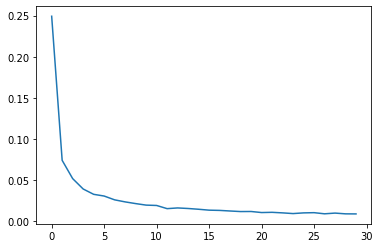

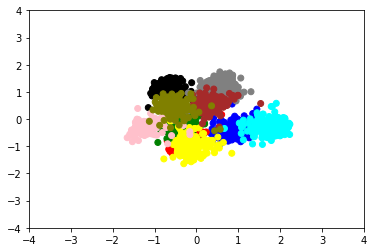

----------Test data visualization----------


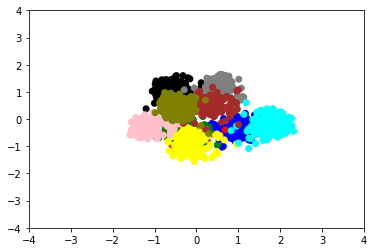

----------Classification Error and Accuracy Report----------
epoch:  1,  TRAIN LOSS: : 2.2536861896514893,  TEST LOSS: : 2.1691436767578125,  TRAIN ACC:  : 12.25,  TEST ACC:  :25.060001373291016
epoch:  2,  TRAIN LOSS: : 2.0798215866088867,  TEST LOSS: : 2.0009963512420654,  TRAIN ACC:  : 38.431663513183594,  TEST ACC:  :49.869998931884766
epoch:  3,  TRAIN LOSS: : 1.9164005517959595,  TEST LOSS: : 1.8422237634658813,  TRAIN ACC:  : 60.474998474121094,  TEST ACC:  :69.27999877929688
epoch:  4,  TRAIN LOSS: : 1.7621225118637085,  TEST LOSS: : 1.692198395729065,  TRAIN ACC:  : 78.82166290283203,  TEST ACC:  :86.38999938964844
epoch:  5,  TRAIN LOSS: : 1.6165707111358643,  TEST LOSS: : 1.550815463066101,  TRAIN ACC:  : 91.09833526611328,  TEST ACC:  :93.72000122070312
epoch:  6,  TRAIN LOSS: : 1.4795259237289429,  TEST LOSS: : 1.4176477193832397,  TRAIN ACC:  : 95.56666564941406,  TEST ACC:  :96.29000091552734
epoch:  7,  TRAIN LOSS: : 1.350813388824463,  TEST LOSS: : 1.2929567098617554, 

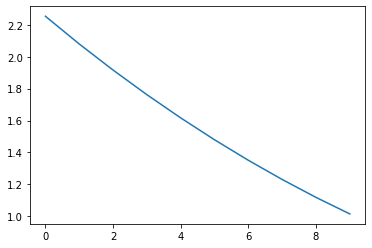

----------Test Classification Error Plot---------


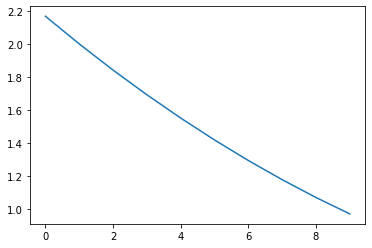

---------Running experiment--------------
learning rate :  1e-05
triplet loss margin :  1
Dropout factor :  0.05
#######################

---------Triplet Loss Report-------------
epoch:  1,  TRAIN TRIPLET LOSS: : 0.25108715891838074
epoch:  2,  TRAIN TRIPLET LOSS: : 0.07163358479738235
epoch:  3,  TRAIN TRIPLET LOSS: : 0.04965423420071602
epoch:  4,  TRAIN TRIPLET LOSS: : 0.04085750877857208
epoch:  5,  TRAIN TRIPLET LOSS: : 0.033105865120887756
epoch:  6,  TRAIN TRIPLET LOSS: : 0.02883092500269413
epoch:  7,  TRAIN TRIPLET LOSS: : 0.02493548020720482
epoch:  8,  TRAIN TRIPLET LOSS: : 0.023072974756360054
epoch:  9,  TRAIN TRIPLET LOSS: : 0.020100677385926247
epoch:  10,  TRAIN TRIPLET LOSS: : 0.020351488143205643
epoch:  11,  TRAIN TRIPLET LOSS: : 0.018022403120994568
epoch:  12,  TRAIN TRIPLET LOSS: : 0.0168787632137537
epoch:  13,  TRAIN TRIPLET LOSS: : 0.015119942836463451
epoch:  14,  TRAIN TRIPLET LOSS: : 0.01570788212120533
epoch:  15,  TRAIN TRIPLET LOSS: : 0.01387083530426025

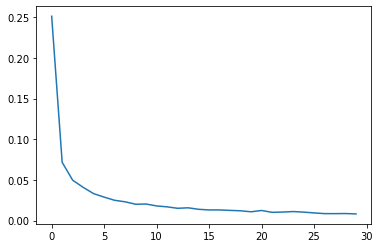

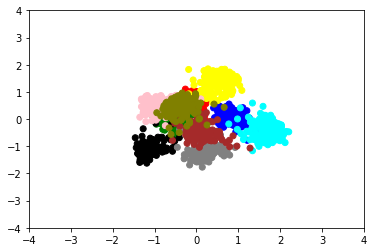

----------Test data visualization----------


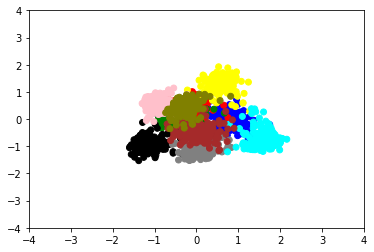

----------Classification Error and Accuracy Report----------
epoch:  1,  TRAIN LOSS: : 2.2529220581054688,  TEST LOSS: : 2.1631367206573486,  TRAIN ACC:  : 15.018333435058594,  TEST ACC:  :21.059999465942383
epoch:  2,  TRAIN LOSS: : 2.0825095176696777,  TEST LOSS: : 1.9973021745681763,  TRAIN ACC:  : 29.498332977294922,  TEST ACC:  :40.15999984741211
epoch:  3,  TRAIN LOSS: : 1.9211950302124023,  TEST LOSS: : 1.8399913311004639,  TRAIN ACC:  : 56.80999755859375,  TEST ACC:  :74.65999603271484
epoch:  4,  TRAIN LOSS: : 1.7684602737426758,  TEST LOSS: : 1.691156268119812,  TRAIN ACC:  : 84.99333190917969,  TEST ACC:  :92.20999908447266
epoch:  5,  TRAIN LOSS: : 1.6235374212265015,  TEST LOSS: : 1.5498900413513184,  TRAIN ACC:  : 94.38999938964844,  TEST ACC:  :96.1300048828125
epoch:  6,  TRAIN LOSS: : 1.486563801765442,  TEST LOSS: : 1.4169992208480835,  TRAIN ACC:  : 96.79666900634766,  TEST ACC:  :97.38999938964844
epoch:  7,  TRAIN LOSS: : 1.3577924966812134,  TEST LOSS: : 1.2922881

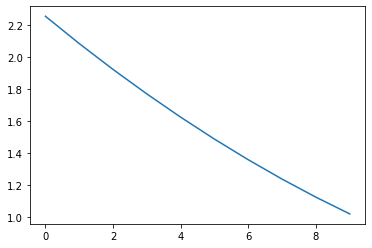

----------Test Classification Error Plot---------


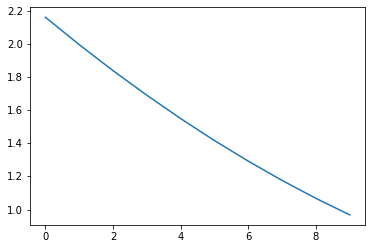

---------Running experiment--------------
learning rate :  1e-05
triplet loss margin :  1
Dropout factor :  0.2
#######################

---------Triplet Loss Report-------------
epoch:  1,  TRAIN TRIPLET LOSS: : 0.24235473573207855
epoch:  2,  TRAIN TRIPLET LOSS: : 0.07148831337690353
epoch:  3,  TRAIN TRIPLET LOSS: : 0.04496561363339424
epoch:  4,  TRAIN TRIPLET LOSS: : 0.03653625398874283
epoch:  5,  TRAIN TRIPLET LOSS: : 0.029579535126686096
epoch:  6,  TRAIN TRIPLET LOSS: : 0.02609110251069069
epoch:  7,  TRAIN TRIPLET LOSS: : 0.023587262257933617
epoch:  8,  TRAIN TRIPLET LOSS: : 0.020404813811182976
epoch:  9,  TRAIN TRIPLET LOSS: : 0.018265828490257263
epoch:  10,  TRAIN TRIPLET LOSS: : 0.01752421446144581
epoch:  11,  TRAIN TRIPLET LOSS: : 0.01526784710586071
epoch:  12,  TRAIN TRIPLET LOSS: : 0.016971437260508537
epoch:  13,  TRAIN TRIPLET LOSS: : 0.014682404696941376
epoch:  14,  TRAIN TRIPLET LOSS: : 0.013428870588541031
epoch:  15,  TRAIN TRIPLET LOSS: : 0.0141038168221712

In [ ]:
#Running the experiment first for mnist
run_experiment(learning_rate=learning_rates[0], margin=margins[0], dropout_factor=dropout_factors[0])
run_experiment(learning_rate=learning_rates[0], margin=margins[0], dropout_factor=dropout_factors[1])

---------Running experiment--------------
learning rate :  0.0001
triplet loss margin :  1
Dropout factor :  0
#######################

---------Triplet Loss Report-------------
epoch:  1,  TRAIN TRIPLET LOSS: : 0.07405612617731094
epoch:  2,  TRAIN TRIPLET LOSS: : 0.02675420604646206
epoch:  3,  TRAIN TRIPLET LOSS: : 0.020464584231376648
epoch:  4,  TRAIN TRIPLET LOSS: : 0.017217133194208145
epoch:  5,  TRAIN TRIPLET LOSS: : 0.015644675120711327
epoch:  6,  TRAIN TRIPLET LOSS: : 0.012806190177798271
epoch:  7,  TRAIN TRIPLET LOSS: : 0.012404664419591427
epoch:  8,  TRAIN TRIPLET LOSS: : 0.011950651183724403
epoch:  9,  TRAIN TRIPLET LOSS: : 0.010978532023727894
epoch:  10,  TRAIN TRIPLET LOSS: : 0.009891309775412083
epoch:  11,  TRAIN TRIPLET LOSS: : 0.00861792080104351
epoch:  12,  TRAIN TRIPLET LOSS: : 0.008968097157776356
epoch:  13,  TRAIN TRIPLET LOSS: : 0.008205008693039417
epoch:  14,  TRAIN TRIPLET LOSS: : 0.007617846596986055
epoch:  15,  TRAIN TRIPLET LOSS: : 0.0076704202219

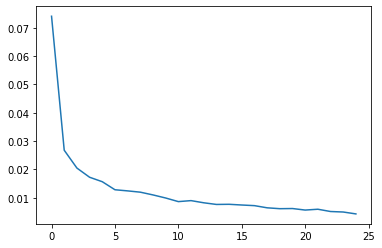

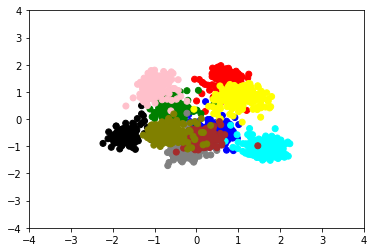

----------Test data visualization----------


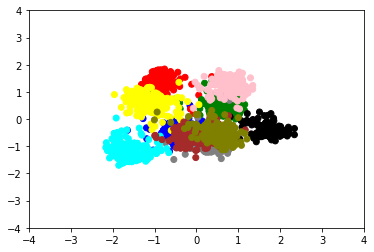

----------Classification Error and Accuracy Report----------
epoch:  1,  TRAIN LOSS: : 1.9740707874298096,  TEST LOSS: : 1.5176501274108887,  TRAIN ACC:  : 44.9900016784668,  TEST ACC:  :94.4000015258789
epoch:  2,  TRAIN LOSS: : 1.171937108039856,  TEST LOSS: : 0.8850775361061096,  TRAIN ACC:  : 97.90999603271484,  TEST ACC:  :98.43999481201172
epoch:  3,  TRAIN LOSS: : 0.6794523596763611,  TEST LOSS: : 0.5183454751968384,  TRAIN ACC:  : 99.11833190917969,  TEST ACC:  :98.7699966430664
epoch:  4,  TRAIN LOSS: : 0.40164241194725037,  TEST LOSS: : 0.3162583112716675,  TRAIN ACC:  : 99.288330078125,  TEST ACC:  :98.87999725341797
epoch:  5,  TRAIN LOSS: : 0.24807798862457275,  TEST LOSS: : 0.20394961535930634,  TRAIN ACC:  : 99.36333465576172,  TEST ACC:  :98.87999725341797
epoch:  6,  TRAIN LOSS: : 0.16146326065063477,  TEST LOSS: : 0.1400454342365265,  TRAIN ACC:  : 99.38333892822266,  TEST ACC:  :98.88999938964844
epoch:  7,  TRAIN LOSS: : 0.11146733909845352,  TEST LOSS: : 0.10274845

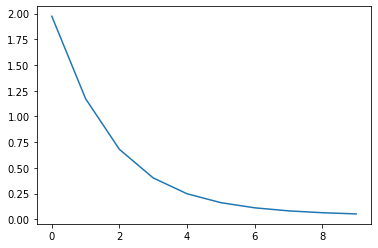

----------Test Classification Error Plot---------


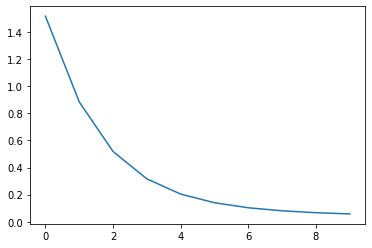

In [ ]:
run_experiment(learning_rate=learning_rates[1], margin=margins[1], dropout_factor=dropout_factors[0])

For mnist learning rate of 1e-04 alongside margin of 1 gave test accuracy close to 99 percent

In [ ]:
#Loading the cifar10 dataset
(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10) = load_dataset(dataset='cifar10')

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
#Basic preprocessing and reshaping of the data
(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10) = preprocess_dataset(x_train_cifar10, y_train_cifar10, x_test_cifar10, y_test_cifar10)

Running for cifar10 with higher margin, learning rate 1e-04 and varying regularization

In [ ]:
#Experiement parameters
learning_rate = 1e-04
margin = 2
dropout_factor = 0.2
epochs = 40

---------Running experiment--------------
learning rate :  0.0001
triplet loss margin :  2
Dropout factor :  0.2
#######################

---------Triplet Loss Report-------------
epoch:  1,  TRAIN TRIPLET LOSS: : 1.3606953620910645
epoch:  2,  TRAIN TRIPLET LOSS: : 1.138358235359192
epoch:  3,  TRAIN TRIPLET LOSS: : 1.0253405570983887
epoch:  4,  TRAIN TRIPLET LOSS: : 0.9408842325210571
epoch:  5,  TRAIN TRIPLET LOSS: : 0.8716803789138794
epoch:  6,  TRAIN TRIPLET LOSS: : 0.816644549369812
epoch:  7,  TRAIN TRIPLET LOSS: : 0.7703648209571838
epoch:  8,  TRAIN TRIPLET LOSS: : 0.7302976846694946
epoch:  9,  TRAIN TRIPLET LOSS: : 0.6817230582237244
epoch:  10,  TRAIN TRIPLET LOSS: : 0.6487160921096802
epoch:  11,  TRAIN TRIPLET LOSS: : 0.6187832951545715
epoch:  12,  TRAIN TRIPLET LOSS: : 0.5870079398155212
epoch:  13,  TRAIN TRIPLET LOSS: : 0.5670260787010193
epoch:  14,  TRAIN TRIPLET LOSS: : 0.5424942374229431
epoch:  15,  TRAIN TRIPLET LOSS: : 0.5221160650253296
epoch:  16,  TRAIN TR

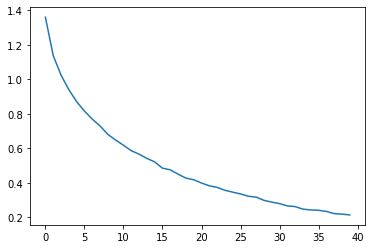

In [ ]:
#First defining the embedding model
triplet_embedding_model = TripletEmbeddingNetwork(dataset='cifar10', 
                                                  dropout=True,
                                                  dropout_factor=dropout_factor)
#Then define the correspondent triplet optimizer
triplet_optimizer = TripletOptimizer(triplet_embedding_model, margin=margin,
                                      lr=learning_rate)
print("---------Running experiment--------------")
print("learning rate : ", learning_rate)
print("triplet loss margin : ", margin)
print("Dropout factor : ", dropout_factor)
print("#######################")
print("")
print("---------Triplet Loss Report-------------")
triplet_loss_history = triplet_optimizer.run(x_train_cifar10, y_train_cifar10, epochs)
print("---------Triplet Loss Plot---------------")
plt.figure()  
plt.plot(triplet_loss_history)
plt.show()      


----------Train data visualization----------


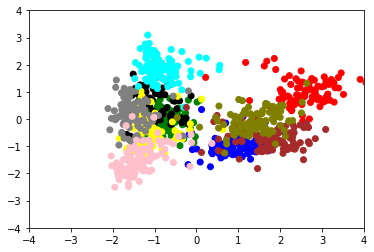

----------Test data visualization----------


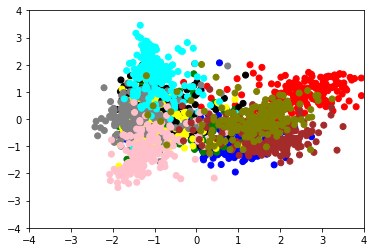

----------Classification Error and Accuracy Report----------
epoch:  1,  TRAIN LOSS: : 1.8123828172683716,  TEST LOSS: : 1.4912816286087036,  TRAIN ACC:  : 46.933998107910156,  TEST ACC:  :61.66999816894531
epoch:  2,  TRAIN LOSS: : 1.1037116050720215,  TEST LOSS: : 1.129757285118103,  TRAIN ACC:  : 78.10599517822266,  TEST ACC:  :68.1500015258789
epoch:  3,  TRAIN LOSS: : 0.7838073968887329,  TEST LOSS: : 0.9636129140853882,  TRAIN ACC:  : 84.36199951171875,  TEST ACC:  :70.95999908447266
epoch:  4,  TRAIN LOSS: : 0.6143353581428528,  TEST LOSS: : 0.880129873752594,  TRAIN ACC:  : 86.68599700927734,  TEST ACC:  :71.73999786376953
epoch:  5,  TRAIN LOSS: : 0.5149258971214294,  TEST LOSS: : 0.8374707102775574,  TRAIN ACC:  : 87.56399536132812,  TEST ACC:  :72.0999984741211
epoch:  6,  TRAIN LOSS: : 0.45351940393447876,  TEST LOSS: : 0.8167139887809753,  TRAIN ACC:  : 87.90399932861328,  TEST ACC:  :72.29999542236328
epoch:  7,  TRAIN LOSS: : 0.4138248860836029,  TEST LOSS: : 0.807878851

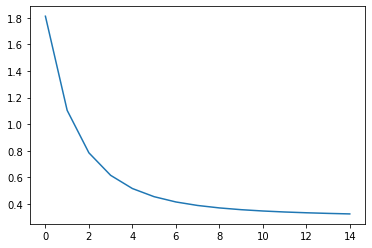

----------Test Classification Error Plot---------


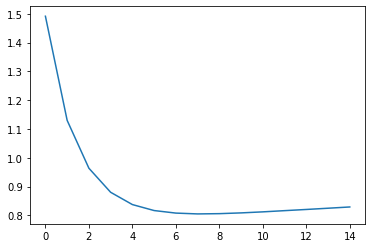

In [ ]:
#Afterwards using the trained embedding model for visualization
embedding_net = triplet_embedding_model.get_model_parameters()
test_data_embedding = embedding_net(x_test_cifar10)
train_data_embedding = embedding_net(x_train_cifar10[:10000])
pca = PCA(2)
test_data_2D = pca.fit_transform(test_data_embedding)
train_data_2D = pca.fit_transform(train_data_embedding)
test_data_2D_dict = reorganize_data(test_data_2D, y_test_cifar10)
train_data_2D_dict = reorganize_data(train_data_2D, y_train_cifar10[:10000])

print("----------Train data visualization----------")
visualize2D_data(train_data_2D_dict,fraction=0.1)

print("----------Test data visualization----------")
visualize2D_data(test_data_2D_dict,fraction=0.2)
#Finally defining a classifier based on the embedding model
print("----------Classification Error and Accuracy Report----------")
image_classifier = ImagesClassifier(embedding_net)
optimizer = Optimizer(image_classifier, mb=32, 
                                loss=tf.keras.losses.SparseCategoricalCrossentropy,
                                lr=learning_rate)
train_history, test_history, train_accuracy, test_accuracy = optimizer.run(x_train_cifar10,
                                                                           y_train_cifar10,
                                                                           x_test_cifar10,
                                                                           y_test_cifar10, 15)


print("----------Train Classification Error Plot---------")
plt.figure()  
plt.plot(train_history)
plt.show()
print("----------Test Classification Error Plot---------")
plt.figure()
plt.plot(test_history)
plt.show()

#Deleting all models and clearing the session before next experiment to 
#save RAM
del triplet_embedding_model
del triplet_optimizer
del optimizer
del image_classifier
tf.keras.backend.clear_session()

In [ ]:
#Experiement parameters
learning_rate = 1e-04
margin = 2
dropout_factor = 0.2
epochs = 40
#Using semi hard negatives mining
semi_hard_negative = True

---------Running experiment--------------
learning rate :  0.0001
triplet loss margin :  2
Dropout factor :  0.2
#######################

---------Triplet Loss Report-------------
epoch:  1,  TRAIN TRIPLET LOSS: : 1.3510849475860596
epoch:  2,  TRAIN TRIPLET LOSS: : 1.122138261795044
epoch:  3,  TRAIN TRIPLET LOSS: : 1.0104684829711914
epoch:  4,  TRAIN TRIPLET LOSS: : 0.9253226518630981
epoch:  5,  TRAIN TRIPLET LOSS: : 0.8604211807250977
epoch:  6,  TRAIN TRIPLET LOSS: : 0.8017412424087524
epoch:  7,  TRAIN TRIPLET LOSS: : 0.7660074830055237
epoch:  8,  TRAIN TRIPLET LOSS: : 0.7207086086273193
epoch:  9,  TRAIN TRIPLET LOSS: : 0.6824917197227478
epoch:  10,  TRAIN TRIPLET LOSS: : 0.643753170967102
epoch:  11,  TRAIN TRIPLET LOSS: : 0.6185604929924011
epoch:  12,  TRAIN TRIPLET LOSS: : 0.5841867327690125
epoch:  13,  TRAIN TRIPLET LOSS: : 0.5670194029808044
epoch:  14,  TRAIN TRIPLET LOSS: : 0.5444260835647583
epoch:  15,  TRAIN TRIPLET LOSS: : 0.5164544582366943
epoch:  16,  TRAIN TR

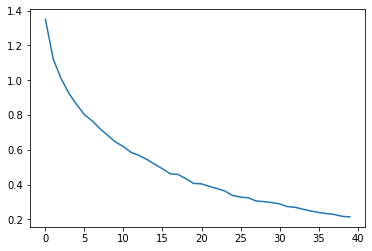

In [ ]:
#First defining the embedding model
triplet_embedding_model = TripletEmbeddingNetwork(dataset='cifar10', 
                                                  dropout=True,
                                                  dropout_factor=dropout_factor)
#Then define the correspondent triplet optimizer
triplet_optimizer = TripletOptimizer(triplet_embedding_model, margin=margin,
                                      lr=learning_rate, semi_hard_negative=semi_hard_negative)
print("---------Running experiment--------------")
print("learning rate : ", learning_rate)
print("triplet loss margin : ", margin)
print("Dropout factor : ", dropout_factor)
print("#######################")
print("")
print("---------Triplet Loss Report-------------")
triplet_loss_history = triplet_optimizer.run(x_train_cifar10, y_train_cifar10, epochs)
print("---------Triplet Loss Plot---------------")
plt.figure()  
plt.plot(triplet_loss_history)
plt.show()     

----------Train data visualization----------


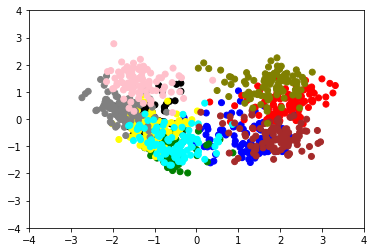

----------Test data visualization----------


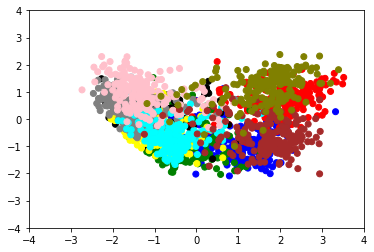

----------Classification Error and Accuracy Report----------
epoch:  1,  TRAIN LOSS: : 1.697821021080017,  TEST LOSS: : 1.4178715944290161,  TRAIN ACC:  : 59.798004150390625,  TEST ACC:  :67.31999969482422
epoch:  2,  TRAIN LOSS: : 1.0140882730484009,  TEST LOSS: : 1.0825775861740112,  TRAIN ACC:  : 83.88800048828125,  TEST ACC:  :70.52000427246094
epoch:  3,  TRAIN LOSS: : 0.7222040295600891,  TEST LOSS: : 0.9349365234375,  TRAIN ACC:  : 86.5,  TEST ACC:  :71.88999938964844
epoch:  4,  TRAIN LOSS: : 0.5718594789505005,  TEST LOSS: : 0.8620070219039917,  TRAIN ACC:  : 87.36799621582031,  TEST ACC:  :72.16999816894531
epoch:  5,  TRAIN LOSS: : 0.4854980707168579,  TEST LOSS: : 0.8262407779693604,  TRAIN ACC:  : 87.8219985961914,  TEST ACC:  :72.29000091552734
epoch:  6,  TRAIN LOSS: : 0.4329400062561035,  TEST LOSS: : 0.8093971014022827,  TRAIN ACC:  : 88.06800079345703,  TEST ACC:  :72.56999969482422
epoch:  7,  TRAIN LOSS: : 0.3991044759750366,  TEST LOSS: : 0.8024986982345581,  TRAIN

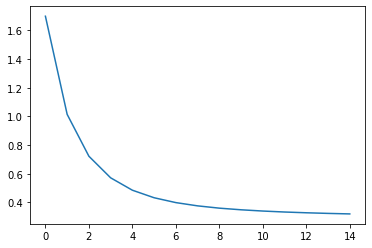

----------Test Classification Error Plot---------


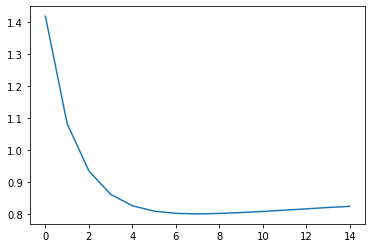

In [ ]:
#Afterwards using the trained embedding model for visualization
embedding_net = triplet_embedding_model.get_model_parameters()
test_data_embedding = embedding_net(x_test_cifar10)
train_data_embedding = embedding_net(x_train_cifar10[:10000])
pca = PCA(2)
test_data_2D = pca.fit_transform(test_data_embedding)
train_data_2D = pca.fit_transform(train_data_embedding)
test_data_2D_dict = reorganize_data(test_data_2D, y_test_cifar10)
train_data_2D_dict = reorganize_data(train_data_2D, y_train_cifar10[:10000])

print("----------Train data visualization----------")
visualize2D_data(train_data_2D_dict,fraction=0.1)

print("----------Test data visualization----------")
visualize2D_data(test_data_2D_dict,fraction=0.2)
#Finally defining a classifier based on the embedding model
print("----------Classification Error and Accuracy Report----------")
image_classifier = ImagesClassifier(embedding_net)
optimizer = Optimizer(image_classifier, mb=32, 
                                loss=tf.keras.losses.SparseCategoricalCrossentropy,
                                lr=learning_rate)
train_history, test_history, train_accuracy, test_accuracy = optimizer.run(x_train_cifar10,
                                                                           y_train_cifar10,
                                                                           x_test_cifar10,
                                                                           y_test_cifar10, 15)


print("----------Train Classification Error Plot---------")
plt.figure()  
plt.plot(train_history)
plt.show()
print("----------Test Classification Error Plot---------")
plt.figure()
plt.plot(test_history)
plt.show()

#Deleting all models and clearing the session before next experiment to 
#save RAM
del triplet_embedding_model
del triplet_optimizer
del optimizer
del image_classifier
tf.keras.backend.clear_session()

In [ ]:
#Experiement parameters
learning_rate = 1e-04
margin = 2
dropout_factor = 0.5
epochs = 40

---------Running experiment--------------
learning rate :  0.0001
triplet loss margin :  2
Dropout factor :  0.5
#######################

---------Triplet Loss Report-------------
epoch:  1,  TRAIN TRIPLET LOSS: : 1.3299720287322998
epoch:  2,  TRAIN TRIPLET LOSS: : 1.1072814464569092
epoch:  3,  TRAIN TRIPLET LOSS: : 0.9916418194770813
epoch:  4,  TRAIN TRIPLET LOSS: : 0.9092485308647156
epoch:  5,  TRAIN TRIPLET LOSS: : 0.8410471081733704
epoch:  6,  TRAIN TRIPLET LOSS: : 0.7848415374755859
epoch:  7,  TRAIN TRIPLET LOSS: : 0.7378764152526855
epoch:  8,  TRAIN TRIPLET LOSS: : 0.6928267478942871
epoch:  9,  TRAIN TRIPLET LOSS: : 0.6642106771469116
epoch:  10,  TRAIN TRIPLET LOSS: : 0.6402930617332458
epoch:  11,  TRAIN TRIPLET LOSS: : 0.6068723797798157
epoch:  12,  TRAIN TRIPLET LOSS: : 0.5665736198425293
epoch:  13,  TRAIN TRIPLET LOSS: : 0.5378472805023193
epoch:  14,  TRAIN TRIPLET LOSS: : 0.528119683265686
epoch:  15,  TRAIN TRIPLET LOSS: : 0.493320494890213
epoch:  16,  TRAIN TR

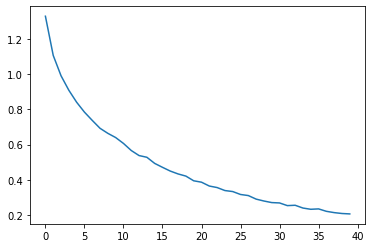

In [ ]:
#First defining the embedding model
triplet_embedding_model = TripletEmbeddingNetwork(dataset='cifar10', 
                                                  dropout=True,
                                                  dropout_factor=dropout_factor)
#Then define the correspondent triplet optimizer
triplet_optimizer = TripletOptimizer(triplet_embedding_model, margin=margin,
                                      lr=learning_rate)
print("---------Running experiment--------------")
print("learning rate : ", learning_rate)
print("triplet loss margin : ", margin)
print("Dropout factor : ", dropout_factor)
print("#######################")
print("")
print("---------Triplet Loss Report-------------")
triplet_loss_history = triplet_optimizer.run(x_train_cifar10, y_train_cifar10, epochs)
print("---------Triplet Loss Plot---------------")
plt.figure()  
plt.plot(triplet_loss_history)
plt.show()      


----------Train data visualization----------


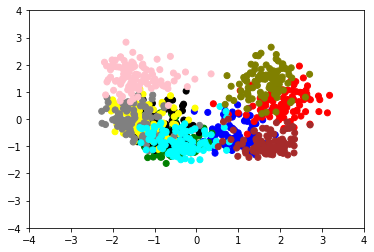

----------Test data visualization----------


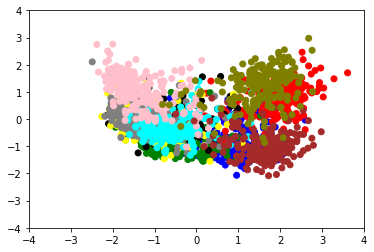

----------Classification Error and Accuracy Report----------
epoch:  1,  TRAIN LOSS: : 1.7865254878997803,  TEST LOSS: : 1.465759515762329,  TRAIN ACC:  : 53.37799835205078,  TEST ACC:  :64.92000579833984
epoch:  2,  TRAIN LOSS: : 1.0677345991134644,  TEST LOSS: : 1.1004308462142944,  TRAIN ACC:  : 81.18000030517578,  TEST ACC:  :70.0999984741211
epoch:  3,  TRAIN LOSS: : 0.7512133121490479,  TEST LOSS: : 0.9372217059135437,  TRAIN ACC:  : 85.76399993896484,  TEST ACC:  :71.7300033569336
epoch:  4,  TRAIN LOSS: : 0.5878084897994995,  TEST LOSS: : 0.8576321601867676,  TRAIN ACC:  : 87.34600067138672,  TEST ACC:  :72.23999786376953
epoch:  5,  TRAIN LOSS: : 0.494384765625,  TEST LOSS: : 0.8182273507118225,  TRAIN ACC:  : 87.91400146484375,  TEST ACC:  :72.43000030517578
epoch:  6,  TRAIN LOSS: : 0.4374361038208008,  TEST LOSS: : 0.7995683550834656,  TRAIN ACC:  : 88.20199584960938,  TEST ACC:  :72.3499984741211
epoch:  7,  TRAIN LOSS: : 0.4008752405643463,  TEST LOSS: : 0.792088985443115

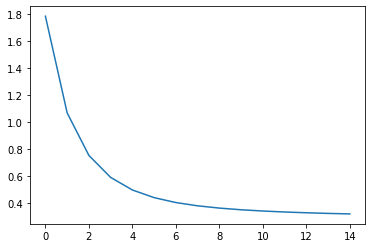

----------Test Classification Error Plot---------


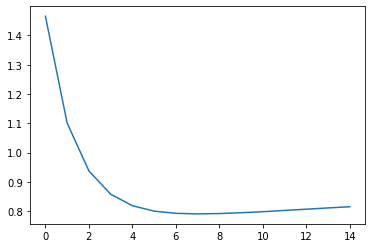

In [ ]:
#Afterwards using the trained embedding model for visualization
embedding_net = triplet_embedding_model.get_model_parameters()
test_data_embedding = embedding_net(x_test_cifar10)
train_data_embedding = embedding_net(x_train_cifar10[:10000])
pca = PCA(2)
test_data_2D = pca.fit_transform(test_data_embedding)
train_data_2D = pca.fit_transform(train_data_embedding)
test_data_2D_dict = reorganize_data(test_data_2D, y_test_cifar10)
train_data_2D_dict = reorganize_data(train_data_2D, y_train_cifar10[:10000])

print("----------Train data visualization----------")
visualize2D_data(train_data_2D_dict,fraction=0.1)

print("----------Test data visualization----------")
visualize2D_data(test_data_2D_dict,fraction=0.2)
#Finally defining a classifier based on the embedding model
print("----------Classification Error and Accuracy Report----------")
image_classifier = ImagesClassifier(embedding_net)
optimizer = Optimizer(image_classifier, mb=32, 
                                loss=tf.keras.losses.SparseCategoricalCrossentropy,
                                lr=learning_rate)
train_history, test_history, train_accuracy, test_accuracy = optimizer.run(x_train_cifar10,
                                                                           y_train_cifar10,
                                                                           x_test_cifar10,
                                                                           y_test_cifar10, 15)


print("----------Train Classification Error Plot---------")
plt.figure()  
plt.plot(train_history)
plt.show()
print("----------Test Classification Error Plot---------")
plt.figure()
plt.plot(test_history)
plt.show()

#Deleting all models and clearing the session before next experiment to 
#save RAM
del triplet_embedding_model
del triplet_optimizer
del optimizer
del image_classifier
tf.keras.backend.clear_session()

In [ ]:
#Experiement parameters
learning_rate = 1e-04
margin = 3
dropout_factor = 0.0
epochs = 50

---------Running experiment--------------
learning rate :  0.0001
triplet loss margin :  3
Dropout factor :  0.0
#######################

---------Triplet Loss Report-------------
epoch:  1,  TRAIN TRIPLET LOSS: : 2.1262338161468506
epoch:  2,  TRAIN TRIPLET LOSS: : 1.8190830945968628
epoch:  3,  TRAIN TRIPLET LOSS: : 1.6661287546157837
epoch:  4,  TRAIN TRIPLET LOSS: : 1.5275747776031494
epoch:  5,  TRAIN TRIPLET LOSS: : 1.4473061561584473
epoch:  6,  TRAIN TRIPLET LOSS: : 1.371085524559021
epoch:  7,  TRAIN TRIPLET LOSS: : 1.2963744401931763
epoch:  8,  TRAIN TRIPLET LOSS: : 1.2555828094482422
epoch:  9,  TRAIN TRIPLET LOSS: : 1.2083988189697266
epoch:  10,  TRAIN TRIPLET LOSS: : 1.1507405042648315
epoch:  11,  TRAIN TRIPLET LOSS: : 1.112614393234253
epoch:  12,  TRAIN TRIPLET LOSS: : 1.0594685077667236
epoch:  13,  TRAIN TRIPLET LOSS: : 1.0498749017715454
epoch:  14,  TRAIN TRIPLET LOSS: : 1.0064643621444702
epoch:  15,  TRAIN TRIPLET LOSS: : 0.9753644466400146
epoch:  16,  TRAIN TR

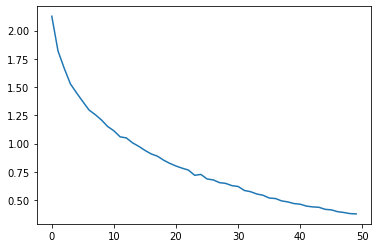

In [ ]:
#First defining the embedding model
triplet_embedding_model = TripletEmbeddingNetwork(dataset='cifar10', 
                                                  dropout=True,
                                                  dropout_factor=dropout_factor)
#Then define the correspondent triplet optimizer
triplet_optimizer = TripletOptimizer(triplet_embedding_model, margin=margin,
                                      lr=learning_rate, mb=32)
print("---------Running experiment--------------")
print("learning rate : ", learning_rate)
print("triplet loss margin : ", margin)
print("Dropout factor : ", dropout_factor)
print("#######################")
print("")
print("---------Triplet Loss Report-------------")
triplet_loss_history = triplet_optimizer.run(x_train_cifar10, y_train_cifar10, epochs)
print("---------Triplet Loss Plot---------------")
plt.figure()  
plt.plot(triplet_loss_history)
plt.show()      

----------Train data visualization----------


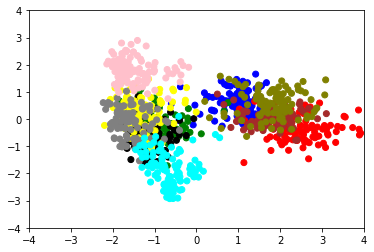

----------Test data visualization----------


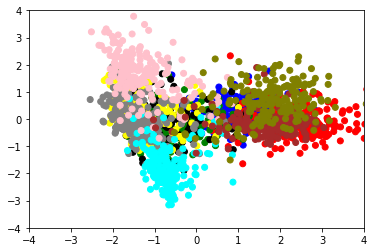

----------Classification Error and Accuracy Report----------
epoch:  1,  TRAIN LOSS: : 1.727027177810669,  TEST LOSS: : 1.3645603656768799,  TRAIN ACC:  : 50.37199783325195,  TEST ACC:  :65.30999755859375
epoch:  2,  TRAIN LOSS: : 0.9809278845787048,  TEST LOSS: : 1.013939619064331,  TRAIN ACC:  : 80.28399658203125,  TEST ACC:  :71.0300064086914
epoch:  3,  TRAIN LOSS: : 0.6934489607810974,  TEST LOSS: : 0.8722483515739441,  TRAIN ACC:  : 84.50199890136719,  TEST ACC:  :72.2699966430664
epoch:  4,  TRAIN LOSS: : 0.5569373965263367,  TEST LOSS: : 0.8087795376777649,  TRAIN ACC:  : 85.56200408935547,  TEST ACC:  :72.8499984741211
epoch:  5,  TRAIN LOSS: : 0.48399078845977783,  TEST LOSS: : 0.7805605530738831,  TRAIN ACC:  : 86.04199981689453,  TEST ACC:  :73.1199951171875
epoch:  6,  TRAIN LOSS: : 0.44217202067375183,  TEST LOSS: : 0.7688412070274353,  TRAIN ACC:  : 86.2280044555664,  TEST ACC:  :73.20999908447266
epoch:  7,  TRAIN LOSS: : 0.4163834750652313,  TEST LOSS: : 0.764947593212

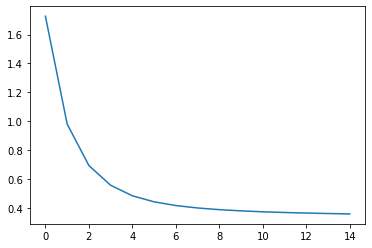

----------Test Classification Error Plot---------


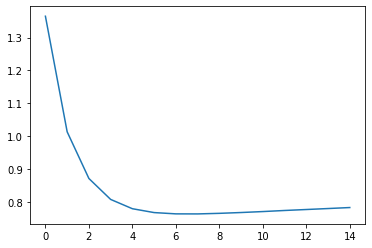

In [ ]:
#Afterwards using the trained embedding model for visualization
embedding_net = triplet_embedding_model.get_model_parameters()
test_data_embedding = embedding_net(x_test_cifar10)
train_data_embedding = embedding_net(x_train_cifar10[:10000])
pca = PCA(2)
test_data_2D = pca.fit_transform(test_data_embedding)
train_data_2D = pca.fit_transform(train_data_embedding)
test_data_2D_dict = reorganize_data(test_data_2D, y_test_cifar10)
train_data_2D_dict = reorganize_data(train_data_2D, y_train_cifar10[:10000])

print("----------Train data visualization----------")
visualize2D_data(train_data_2D_dict,fraction=0.1)

print("----------Test data visualization----------")
visualize2D_data(test_data_2D_dict,fraction=0.2)
#Finally defining a classifier based on the embedding model
print("----------Classification Error and Accuracy Report----------")
image_classifier = ImagesClassifier(embedding_net)
optimizer = Optimizer(image_classifier, mb=32, 
                                loss=tf.keras.losses.SparseCategoricalCrossentropy,
                                lr=learning_rate)
train_history, test_history, train_accuracy, test_accuracy = optimizer.run(x_train_cifar10,
                                                                           y_train_cifar10,
                                                                           x_test_cifar10,
                                                                           y_test_cifar10, 15)


print("----------Train Classification Error Plot---------")
plt.figure()  
plt.plot(train_history)
plt.show()
print("----------Test Classification Error Plot---------")
plt.figure()
plt.plot(test_history)
plt.show()

#Deleting all models and clearing the session before next experiment to 
#save RAM
del triplet_embedding_model
del triplet_optimizer
del optimizer
del image_classifier
tf.keras.backend.clear_session()

For cifar-10 the test accuracy was always around 73 percent and train accuracy around 90 percent

# Conclusion



*   Deep metric learning works with image classification as seen from the 2D visualizations where each class's instances were close to each other.
*   Worked great with mnist achieving 99 percent test accuracy.
*   Triplet choice is important factor in performance as choosing harder negatives should make the benefits of each iteration higher.
*   That is why randomly choosing triplets did not work well with cifar10 even after applying dropout regularization, achieving only 73.5 percent accuracy.
*   Semi-hard negatives mining was tried but did not achieve improvement in the performance.
*   Improvements could easily be done by doing hard negative data mining as suggested in [4].







# References








[1] Wang, Zhuoyi & Tao, Hemeng & Kong, Zelun & Chandra, Swarup & Khan, Latifur. (2019). Metric Learning based Framework for Streaming Classification with Concept Evolution. 1-8. 10.1109/IJCNN.2019.8851934. 

[2] Hoffer, Elad, and Nir Ailon. "Deep metric learning using triplet network." International workshop on similarity-based pattern recognition. Springer, Cham, 2015.

[3] https://www.kaggle.com/guichristmann/training-a-triplet-loss-model-on-mnist

[4] Schroff, Florian, Dmitry Kalenichenko, and James Philbin. "Facenet: A unified embedding for face recognition and clustering." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.

[5] stackoverflow post https://stackoverflow.com/questions/53630158/add-points-to-the-existing-matplotlib-scatter-plot